In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Taille train complète : 5728
Taille val complète   : 448
Taille train subset : 2005
Taille val subset   : 134

Distribution des classes (train subset) :
label
0     142
1      51
2      96
3     222
4     101
5      57
6      58
7     182
8      58
9     163
10    102
11     51
12     66
13    152
14     97
15     37
16    175
17     73
18     91
19     31
Name: count, dtype: int64

Distribution des classes (val subset) :
label
0      5
1      8
2      7
3     19
4     11
5      2
6      4
7     12
8      1
9     13
10     5
11     5
12     4
13     6
14     6
15     2
16    11
17     6
18     5
19     2
Name: count, dtype: int64


/tmp/ipython-input-4027974609.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_counts.index, y=train_counts.values, palette="viridis")
/tmp/ipython-input-4027974609.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_counts.index, y=val_counts.values, palette="magma")


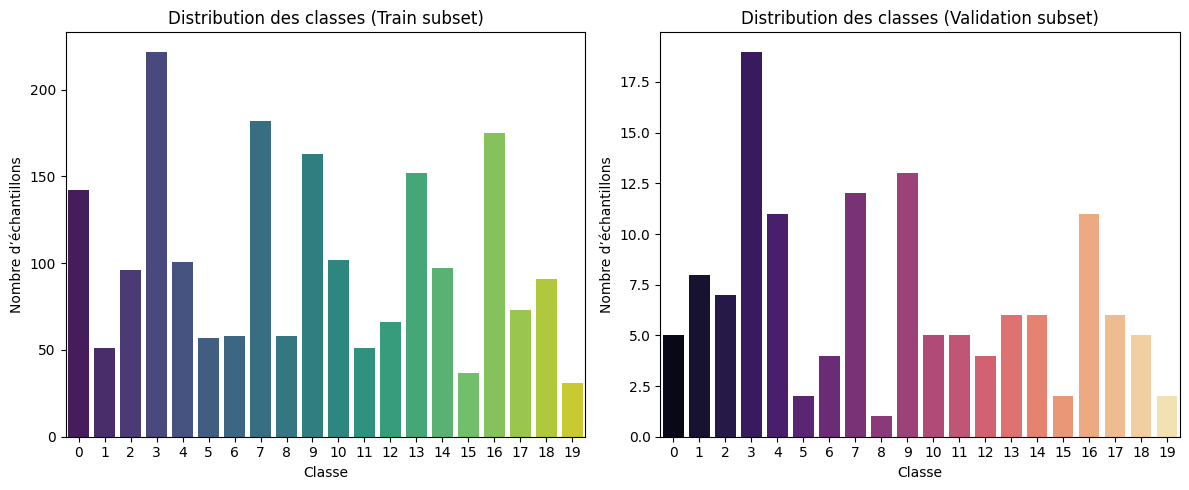

In [ ]:
# =========================
# ÉTAPE 1 — Seed + sous-échantillon + visualisation classes
# =========================

import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os, math, time, json, random
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix

def same_seeds(seed: int = 42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)


# 2. Chemins de tes données
base_audio_dir = "/content/drive/MyDrive/Projet non-alternant/Corpus/train_val_videos/TrainValAudio"
train_csv = "/content/drive/MyDrive/Projet non-alternant/Corpus/csv/train_audio_labels.csv"
val_csv   = "/content/drive/MyDrive/Projet non-alternant/Corpus/csv/val_audio_labels.csv"

# 3. Charger les CSV complets
full_train_df = pd.read_csv(train_csv)
full_val_df   = pd.read_csv(val_csv)

# 4. Ajouter les chemins vers les fichiers audio
full_train_df["filepath"] = full_train_df["video_id"].apply(
    lambda x: os.path.join(base_audio_dir, f"{x}.wav")
)
full_val_df["filepath"] = full_val_df["video_id"].apply(
    lambda x: os.path.join(base_audio_dir, f"{x}.wav")
)

print("Taille train complète :", len(full_train_df))
print("Taille val complète   :", len(full_val_df))

# 5. Sous-échantillonnage (modifiable selon ta RAM)
train_frac = 0.35
val_frac   = 0.30

train_df = full_train_df.sample(frac=train_frac, random_state=42).reset_index(drop=True)
val_df   = full_val_df.sample(frac=val_frac,   random_state=42).reset_index(drop=True)

print("Taille train subset :", len(train_df))
print("Taille val subset   :", len(val_df))

# 6. Comptage par classe
train_counts = train_df["label"].value_counts().sort_index()
val_counts   = val_df["label"].value_counts().sort_index()

print("\nDistribution des classes (train subset) :")
print(train_counts)
print("\nDistribution des classes (val subset) :")
print(val_counts)

# 7. 🔥 Visualisation des distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=train_counts.index, y=train_counts.values, palette="viridis")
plt.title("Distribution des classes (Train subset)")
plt.xlabel("Classe")
plt.ylabel("Nombre d’échantillons")

plt.subplot(1, 2, 2)
sns.barplot(x=val_counts.index, y=val_counts.values, palette="magma")
plt.title("Distribution des classes (Validation subset)")
plt.xlabel("Classe")
plt.ylabel("Nombre d’échantillons")

plt.tight_layout()
plt.show()


Nombre total de classes : 20

Poids calculés pour chaque classe :
Classe 0: 0.5290
Classe 1: 1.4728
Classe 2: 0.7824
Classe 3: 0.3383
Classe 4: 0.7437
Classe 5: 1.3178
Classe 6: 1.2950
Classe 7: 0.4127
Classe 8: 1.2950
Classe 9: 0.4608
Classe 10: 0.7364
Classe 11: 1.4728
Classe 12: 1.1381
Classe 13: 0.4942
Classe 14: 0.7744
Classe 15: 2.0301
Classe 16: 0.4292
Classe 17: 1.0289
Classe 18: 0.8254
Classe 19: 2.4230


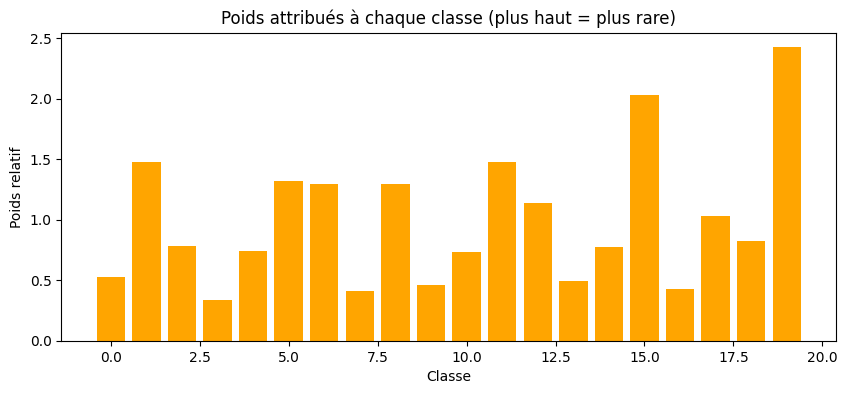

In [ ]:
# =========================
# ÉTAPE 2 — Calcul et visualisation des poids de classes
# =========================

import torch
import matplotlib.pyplot as plt

# 1️⃣ Récupérer le nombre d'exemples par classe
class_counts = train_df["label"].value_counts().sort_index()
num_classes = len(class_counts)
print(f"Nombre total de classes : {num_classes}")

# 2️⃣ Calculer les poids inverses de fréquence
#    (plus une classe est rare -> plus son poids est élevé)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * num_classes  # normalisation
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float32)

print("\nPoids calculés pour chaque classe :")
for i, w in enumerate(class_weights_tensor):
    print(f"Classe {i}: {w:.4f}")

# 3️⃣ Visualiser ces poids
plt.figure(figsize=(10,4))
plt.bar(range(num_classes), class_weights_tensor.numpy(), color='orange')
plt.title("Poids attribués à chaque classe (plus haut = plus rare)")
plt.xlabel("Classe")
plt.ylabel("Poids relatif")
plt.show()

# ✅ Maintenant on a un tenseur prêt à passer à CrossEntropyLoss :
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))


In [ ]:
!pip uninstall -y panns-inference
!pip install git+https://github.com/qiuqiangkong/panns_inference.git

  Cloning https://github.com/qiuqiangkong/panns_inference.git to /tmp/pip-req-build-g55f7xhd
  Running command git clone --filter=blob:none --quiet https://github.com/qiuqiangkong/panns_inference.git /tmp/pip-req-build-g55f7xhd
  Resolved https://github.com/qiuqiangkong/panns_inference.git to commit f673f604ec6f4805a61c5b3be087e24776ec5fda
  Preparing metadata (setup.py) ... done
  Created wheel for panns-inference: filename=panns_inference-0.1.1-py3-none-any.whl size=8266 sha256=6a17efc0a88c57b80b6407ee43a7c8f3884f74fb333abec871a28e159809625b
  Stored in directory: /tmp/pip-ephem-wheel-cache-1u43jqnw/wheels/5c/08/31/c5c15dc831124f27580b43c2940c6bfd9d9b789e175047d7c4
Successfully built panns-inference


In [ ]:
from panns_inference.models import Cnn14

model = Cnn14(sample_rate=16000, window_size=1024, hop_size=320, mel_bins=64, fmin=50, fmax=8000, classes_num=527)
print("✅ Import réussi !")
print(model.__class__.__name__, "chargé avec succès.")

✅ Import réussi !
Cnn14 chargé avec succès.


In [ ]:
# =========================
# ÉTAPE 3 — Dataset + DataLoader + Modèle PANNs + Loss pondérée
# =========================

import torchaudio
from torch.utils.data import Dataset, DataLoader
from panns_inference.models import Cnn14
import torch.nn as nn

# ---- 1️⃣ Dataset personnalisé ----
class AudioDataset(Dataset):
    def __init__(self, df, target_sr=16000, duration=10.0):
        self.df = df.reset_index(drop=True)
        self.target_sr = target_sr
        self.max_length = int(target_sr * duration)
        self.resampler = torchaudio.transforms.Resample(orig_freq=22050, new_freq=target_sr)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filepath = row["filepath"]
        label = int(row["label"])

        # Après avoir chargé l’audio :
        waveform, sr = torchaudio.load(filepath)

        # Si stéréo → convertir en mono
        if waveform.shape[0] > 1:
          waveform = waveform.mean(dim=0, keepdim=True)


        # Si audio trop court -> padding, sinon truncation
        if waveform.shape[1] < self.max_length:
            pad = self.max_length - waveform.shape[1]
            waveform = nn.functional.pad(waveform, (0, pad))
        else:
            waveform = waveform[:, :self.max_length]

        return waveform, label


# ---- 2️⃣ DataLoaders ----
batch_size = 16

train_dataset = AudioDataset(train_df)
val_dataset   = AudioDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ---- 3️⃣ Charger Cnn14 préentraîné et adapter à 20 classes ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device :", device)

# ⭐ Paramètres conformes au checkpoint officiel (corrige le mismatch)
pretrained_model = Cnn14(
    sample_rate=16000,
    window_size=512,      # ✅ au lieu de 1024
    hop_size=160,         # ✅ au lieu de 320
    mel_bins=64,
    fmin=50, fmax=8000,
    classes_num=527
)
checkpoint_path = "/content/drive/MyDrive/Projet non-alternant/Audio/PANNs/Cnn14_16k_mAP=0.438 (1).pth"

# Charger les poids du checkpoint officiel
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

# ⭐ Charger les poids avec strict=False (tolère la tête différente)
pretrained_model.load_state_dict(checkpoint["model"], strict=False)

# ⭐ Adapter la tête de classification à tes 20 classes
pretrained_model.fc_audioset = nn.Linear(2048, 20)

model = pretrained_model.to(device)
model.train()

# ---- 4️⃣ Définir la loss pondérée ----
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

# ---- 5️⃣ Optimizer ----
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("\n✅ Modèle prêt pour l'entraînement pondéré sur sous-échantillon !")
print("\n✅ Modèle PANNs (Cnn14) chargé et adapté à 20 classes.")
print("Batch example shape:", next(iter(train_loader))[0].shape)


✅ Device : cuda

✅ Modèle prêt pour l'entraînement pondéré sur sous-échantillon !

✅ Modèle PANNs (Cnn14) chargé et adapté à 20 classes.


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Batch example shape: torch.Size([16, 1, 160000])


🚀 Démarrage de l'entraînement sur 15 époques...


Epoch 1/15:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a


📊 Epoch 1/15
Train Loss: 2.9856 | Train Acc: 0.1162
Val Loss:   2.9796 | Val Acc:   0.1567
✅ Nouveau meilleur modèle sauvegardé (Val Acc = 0.1567)


Epoch 2/15:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a


📊 Epoch 2/15
Train Loss: 2.9460 | Train Acc: 0.1865
Val Loss:   2.9337 | Val Acc:   0.2015
✅ Nouveau meilleur modèle sauvegardé (Val Acc = 0.2015)


Epoch 3/15:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a


📊 Epoch 3/15
Train Loss: 2.8276 | Train Acc: 0.1880
Val Loss:   2.8224 | Val Acc:   0.2463
✅ Nouveau meilleur modèle sauvegardé (Val Acc = 0.2463)


Epoch 4/15:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a


📊 Epoch 4/15
Train Loss: 2.7625 | Train Acc: 0.2389
Val Loss:   2.7789 | Val Acc:   0.2537
✅ Nouveau meilleur modèle sauvegardé (Val Acc = 0.2537)


Epoch 5/15:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a


📊 Epoch 5/15
Train Loss: 2.6953 | Train Acc: 0.2788
Val Loss:   2.7546 | Val Acc:   0.2687
✅ Nouveau meilleur modèle sauvegardé (Val Acc = 0.2687)


Epoch 6/15:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a


📊 Epoch 6/15
Train Loss: 2.6647 | Train Acc: 0.2978
Val Loss:   2.7596 | Val Acc:   0.2463


Epoch 7/15:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a


📊 Epoch 7/15
Train Loss: 2.6252 | Train Acc: 0.3172
Val Loss:   2.7556 | Val Acc:   0.2239


Epoch 8/15:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a


📊 Epoch 8/15
Train Loss: 2.6121 | Train Acc: 0.3227
Val Loss:   2.7312 | Val Acc:   0.2388


Epoch 9/15:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a


📊 Epoch 9/15
Train Loss: 2.5820 | Train Acc: 0.3337
Val Loss:   2.7507 | Val Acc:   0.2612


Epoch 10/15:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/


📊 Epoch 10/15
Train Loss: 2.5616 | Train Acc: 0.3766
Val Loss:   2.7421 | Val Acc:   0.2313


Epoch 11/15:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/


📊 Epoch 11/15
Train Loss: 2.5462 | Train Acc: 0.3616
Val Loss:   2.7333 | Val Acc:   0.2313


Epoch 12/15:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/


📊 Epoch 12/15
Train Loss: 2.5218 | Train Acc: 0.4130
Val Loss:   2.7205 | Val Acc:   0.2463


Epoch 13/15:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/


📊 Epoch 13/15
Train Loss: 2.4943 | Train Acc: 0.4204
Val Loss:   2.7252 | Val Acc:   0.2687


Epoch 14/15:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/


📊 Epoch 14/15
Train Loss: 2.4914 | Train Acc: 0.4244
Val Loss:   2.7341 | Val Acc:   0.2313


Epoch 15/15:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/


📊 Epoch 15/15
Train Loss: 2.4775 | Train Acc: 0.4384
Val Loss:   2.7359 | Val Acc:   0.2463

🏁 Entraînement terminé. Meilleure Val Acc : 0.2687


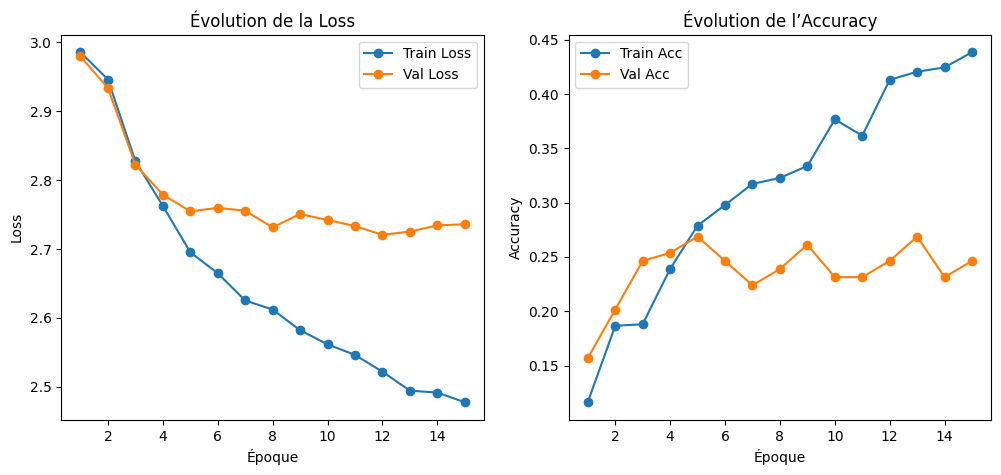


🔍 Évaluation finale sur le set de validation...


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r


📋 Rapport de classification (par classe) :
              precision    recall  f1-score   support

           0      0.091     0.200     0.125         5
           1      0.333     0.125     0.182         8
           2      0.273     0.429     0.333         7
           3      0.348     0.421     0.381        19
           4      0.250     0.273     0.261        11
           5      0.167     1.000     0.286         2
           6      0.000     0.000     0.000         4
           7      0.800     0.333     0.471        12
           8      0.000     0.000     0.000         1
           9      0.500     0.385     0.435        13
          10      0.167     0.200     0.182         5
          11      0.167     0.200     0.182         5
          12      0.500     0.250     0.333         4
          13      0.500     0.167     0.250         6
          14      0.000     0.000     0.000         6
          15      0.000     0.000     0.000         2
          16      0.400     0.364    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


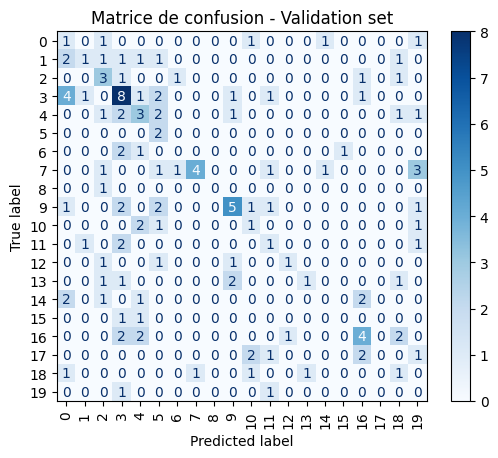

In [ ]:
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# =============================
# ⚙️ CONFIGURATION
# =============================
num_epochs = 15
best_val_acc = 0.0

# Pour enregistrer les historiques
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

print(f"🚀 Démarrage de l'entraînement sur {num_epochs} époques...")

# =============================
# 🧠 ENTRAÎNEMENT
# =============================
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0

    # -------------------------
    # 🟩 Entraînement
    # -------------------------
    for waveforms, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        waveforms, labels = waveforms.to(device), labels.to(device)

        # Convertir en mono
        if waveforms.ndim == 3:
            waveforms = torch.mean(waveforms, dim=1)

        optimizer.zero_grad()
        output_dict = model(waveforms)
        outputs = output_dict["clipwise_output"]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Stats
        train_loss += loss.item() * waveforms.size(0)
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = train_correct / total

    # -------------------------
    # 🟦 Validation
    # -------------------------
    model.eval()
    val_loss, val_correct, total_val = 0.0, 0, 0

    with torch.no_grad():
        for waveforms, labels in val_loader:
            waveforms, labels = waveforms.to(device), labels.to(device)
            if waveforms.ndim == 3:
                waveforms = torch.mean(waveforms, dim=1)
            output_dict = model(waveforms)
            outputs = output_dict["clipwise_output"]
            loss = criterion(outputs, labels)

            val_loss += loss.item() * waveforms.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= total_val
    val_acc = val_correct / total_val

    # 🔢 Sauvegarde historique
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"\n📊 Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    # 💾 Sauvegarde du meilleur modèle
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/best_panns_subset.pt")
        print(f"✅ Nouveau meilleur modèle sauvegardé (Val Acc = {val_acc:.4f})")

print(f"\n🏁 Entraînement terminé. Meilleure Val Acc : {best_val_acc:.4f}")

# =============================
# 📈 VISUALISATION COURBES
# =============================
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.title("Évolution de la Loss")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Acc', marker='o')
plt.plot(epochs, val_accuracies, label='Val Acc', marker='o')
plt.title("Évolution de l’Accuracy")
plt.xlabel("Époque")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# =============================
# 🧪 ÉVALUATION FINALE
# =============================
print("\n🔍 Évaluation finale sur le set de validation...")

model.load_state_dict(torch.load("/content/best_panns_subset.pt", map_location=device))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for waveforms, labels in val_loader:
        waveforms = torch.mean(waveforms, dim=1).to(device)
        labels = labels.to(device)
        outputs = model(waveforms)["clipwise_output"]
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Rapport par classe
print("\n📋 Rapport de classification (par classe) :")
print(classification_report(all_labels, all_preds, digits=3))

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Matrice de confusion - Validation set")
plt.show()

